MLC Project: Genetric Programming on Bitcoin Trading
===
Contents
---
A: Introduction
   > A1: Genetic Programming  
   > A2: Fitness Function  
   > A3: Crossover & Selection  
   > A4: Mutation  

B: Algorithms && Implementation
   > B1: Data Preprocessing  
   > B2: Syntax Tree Construction
   
C: Results && Discussion
   > C1: Cross Validation  
   > C2: Learning Curve
   
D: Conclusion

A: Introduction
===
### A1: Genetic Programming
Genetic programming developed by John Koza(1992) is an extension of genetic algorithms. It is a machine learning technique that aims to automatically produce executable programs that solve problems independently of their domain. In GP, solution candidates are represented as hierarchical of functions, aka syntax tree. 

![](http://deap.readthedocs.io/en/master/_images/gptree.png)  
_figure 1: A program that can undergoes Evolution Algorithms_  

For instance, the above figure represents the program $max(x+3*y, x+x)$. This program takes two input arguments `x,y` and leads to a numerical output. Programs and nodes are interpreted as individuals organisms and gene respectively. A Groups of individuals, namely a population, is defined when genes are defined by users with specific tasks. In this case `max(), +, *` are the genes. A __fitness function__ is then used as survival pressure that drives a Darwinian natural selection process on initial populations. Therefore, fittest offsprings are produced as individuals mate and their genes cross and mutate.

### A2: Fitness Function
In this project, the fitness function is based on excess return over a buy-and-hold strategy:

$$fitness = r - r_{bh}$$

$$r= \sum_{n=1}^{T}r_t \cdot I_b(t) + \sum_{n=1}^{T}r_f \cdot I_t(t) + n 
\cdot log\frac{1-c}{1+c} $$

$$r_{bh}= \sum_{n=1}^{T}r_t + log\frac{1-c}{1+c} $$


$r$: continuosly compounded return  
$r_{bh}$: return for a buy-and-hold strategy (buy the first day, sell the last day)  
$r_t$: aily continuously compouned return where $r_t = logP_t - logP_{t-1} $  
$I_b(t), I_s(t)$: equal to one if a rule signals "buy" and "sell".  
$c$: one way transcation cost.

While there are different alternative fitness functions, for instance,  a fitness function that penalizes for large daily losses or for large drawdowns of wealth, we use this fitness function because it: (1) accounts for translation costs (2) accounts for returns from risk-free investment when withdrawing from bitcoin market, in our case 3-month T-bill (3) benchmarks with a naive investment rule so that outputs are relative value instead of absolute value.

### A3: Crossover & Selection
The crossover operator is parallel to reproduction and biological crossover. In other words, individuals selected as parents mate and contribute genetic material and produce offsprings that hopefully carries more competitive attribute in the particular environments. Whatever will be passed on to the future generations depends on methods for selection of the chromosomes.  

Common techniques for crossover include `single-point, two-point, Uniform and half uniform, etc` and for selection include `Boltzmann selection, Rank selection, Tournament selection, etc`. We also note that these techniques are far less sophisticated from their biological counterparts. The designer might choose to implement a problem-specific crossover operator with expert domain knowledge. This project uses the simplest `single-point` for crossover and `tournament selection` for selection. 
In the single-point crossover, a random crossover point is selected and the tails of its two parents are swapped to get new off-springs.Tournaments Selection creates "tournaments" among few individuals or chromosomes chosen at random from the population. The winner of each tournament is selected for crossover. 

![](https://www.tutorialspoint.com/genetic_algorithms/images/one_point_crossover.jpg)
_figure 2: single-point crossover: two pieces of genes performs crossover by swapping substructure inplace_

### A4: Mutation 
Analogous to biological mutation, mutation alters some genes values in a chromosome from their initial state. Similar to biological mutation, mutating programs will result in a more diverse population so that a larger solution space can be searched. In other words, a random mutation may swing a population out from stuck at a local minimum. This project uses `uniform mutation` that is to select a point in the syntax tree and replace the subtree at that point as a root by the randomly generated individual with a maximum depth of 3.

![](https://s-media-cache-ak0.pinimg.com/236x/80/58/79/805879123862819253b32b86c525f777.jpg)
_figure 3: A mutation has caused this red tulip to have one petal being yellow. While it's hard to tell whether this mutated attribute is an advantageous change or not, it does make interesting looking flowers to look at_

B: Algorithms && Implementation
===
### B1: Data Preprocessing
The data used in this projected are scrapped or downloaded from online. Specifically, I used bitcoin market data from [Coindesk](http://www.coindesk.com/price/) and Treasury Bill data from 2012 May 10th -2017 May 9th from the [U.S Department of Tresury](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates). These data are aggregated and stored in a single data frame. 

The preprocessing operations include (1) Fill out the missing value for `T-Bill 3 month` by taking the average of the forward and backward rows with numerical values. Note that this feature is used as a risk-free return to calculate the returns when the algorithms tell investors to move out the bitcoin market. (2) Normalize each feature by making them zero-mean and unit variance.

An interactive plot that includes all time series data was used for exploring.

In [231]:
import deap
from deap import algorithms, base, creator, tools, gp
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from itertools import *
import itertools
import random
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import StandardScaler
import pickle


input_dir = os.getcwd() + "\\input"
df_VOL_PRICE = pd.read_csv(input_dir + "\\2012_2017_VOL_PRICE.csv")
df_OHLC = pd.read_csv(input_dir + "\\2012_2017_OHLC.csv")        
df_TBILL_FULL = pd.read_csv(input_dir + "\\2012_2017_TBILL.csv")
df_TBILL_3M = df_TBILL_FULL.loc[:,['Date','3 Mo']]


df = df_VOL_PRICE.merge(df_OHLC, on = "Date")
df = df.merge(df_TBILL_3M, on= "Date", how = 'outer')

print("Data Frame has Shape: ", df.shape)
df.head()

Data Frame has Shape:  (1826, 8)


,Date,price,volume,Open,High,Low,Close,3 Mo
0,5/10/2012,5.010160,355624.58540,5.04,5.12,4.80,4.85,0.1
1,5/11/2012,4.938945,323526.22740,4.85,5.00,4.80,4.96,0.1
2,5/12/2012,4.927583,106725.79760,4.96,5.00,4.91,4.95,NaN
3,5/13/2012,4.933647,79315.82821,4.95,5.00,4.92,4.93,NaN
4,5/14/2012,4.950240,274810.63920,4.93,5.04,4.90,5.01,0.1


In [234]:
# Daily Compond Rate:
prices = np.asarray(df['price'])
rt = np.log(prices)-shift(np.log(prices),1)
rt[0]=0
df['Daily Compound'] = rt

# Daily T-Bill Rate
# Fill Missing 3-Mon T-bill: take average of foward and backward value
df["Date"] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
df.loc[:,['3 Mo']] = (df.fillna(method = 'ffill')['3 Mo'] + df.fillna(method = 'bfill')['3 Mo'])/2

# Stander Scalerize Dataframe
scale = StandardScaler()
df[['price','volume','Open','High','Low','Close']] =\
scale.fit_transform(df[['price','volume','Open','High','Low','Close']])

df.head()

,Date,price,volume,Open,High,Low,Close,3 Mo,Daily Compound
0,2012-05-10,-1.227153,-0.792018,-1.224739,-1.222957,-1.224428,-1.222983,0.1,0.000000
1,2012-05-11,-1.227380,-0.793006,-1.225343,-1.223329,-1.224428,-1.222634,0.1,-0.014316
2,2012-05-12,-1.227416,-0.799679,-1.224994,-1.223329,-1.224070,-1.222666,0.1,-0.002303
3,2012-05-13,-1.227396,-0.800522,-1.225025,-1.223329,-1.224037,-1.222729,0.1,0.001230
4,2012-05-14,-1.227344,-0.794505,-1.225089,-1.223205,-1.224102,-1.222476,0.1,0.003358


In [235]:
import cufflinks as cf
df_time_index = df.copy()
df_time_index.Date = pd.to_datetime(df['Date'])
df_time_index.set_index(['Date'], inplace = True)
df_time_index.iplot(kind='area',fill=True)

It is interesting to note that the bitcoin price follows very closely with the trend of 3-Month T-bill. In addition, we can also identify the turnover of bitcoin price around Nov. 2013 and other fluctuations.

B2: Syntax Tree Construction
---
Primitives, terminals (i.e inputs) and fitness function are the three backbones of a genetic programming algorithm. While the first version of implementation uses a single group of `price, volume` as inputs for the program. I decided to go with using a data frame with contains all history up to a certain time point as inputs. The intuition is to hope that the evolution process will generate some functions that generate contents that are like the technical index used in the modern technical analysis, for instance, momentum, rolling mean, ROC, etc.

To start, we create a container for a tree by `pset = gp.PrimitiveSetTyped("MAIN", [pd.DataFrame], bool)`. This means that the program takes a data frame as input and output a Boolean: True or False. The output boolean will be interpreted "Buy" and "Sell" in the fitness function `evalCoinInvestor`. The primitives include Boolean operators ("and", "or", "not), arithmetic operators that act on numerical values ($+,-,*,/)$, logics ("greater or equal to", "less than"). In addition, a self-defined function `get_feature_n` takes three inputs and return a feature value with specified index and feature name. Note that, when "True", "False" enters this function, it returns the value of a feature at the latest date by construction.

In [3]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def get_feature_n(dataframe, f_name, n):
    """
    args:
        dataframe: partial dataframe
        f_name: "price", "volume", etc.
        ind: dataframe index
        
    return: 
        [float] ex: "price" with index "4" (4.933647) 
    """
    try:
        return dataframe.iloc[n][f_name]
    except TypeError: #<-------------------------------------------Caused by True && False
        return dataframe.iloc[len(dataframe)-1]['price'] 

def get_self(stuff):
    return stuff

    
pset = gp.PrimitiveSetTyped("MAIN", [pd.DataFrame], bool)

# Basic Boolean Operations
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# Basic Arithmetic Operations 
pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(protectedDiv, [float,float], float)

# Logics
pset.addPrimitive(operator.ge, [float, float], bool)   
pset.addPrimitive(operator.lt, [float, float], bool)

# Self-defined Prim.
pset.addPrimitive(get_feature_n, [pd.DataFrame, str, int], float)
pset.addPrimitive(get_self, [pd.DataFrame], pd.DataFrame)
pset.addPrimitive(get_self, [str], str)
pset.addPrimitive(get_self, [bool], bool)
pset.addPrimitive(get_self, [int], int)
pset.addPrimitive(get_self, [float], float)
pset.addEphemeralConstant("rand10", lambda: random.random() * 10, float)
pset.addEphemeralConstant("rand_int_30", lambda: np.random.randint(30), int)

pset.addTerminal(True, bool)
pset.addTerminal(False, bool)
pset.addTerminal("price", str)
pset.addTerminal("volume", str)
# pset.addTerminal("Open", str)
# pset.addTerminal("Close", str)
# pset.addTerminal("High", str)
# pset.addTerminal("Low", str)
pset.renameArguments(ARG0="DF")

# Creator: Wrapping Individual && Fitness Function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# Structure
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalCoinInvestor(individual, dataframe):
    num_stock = 0
    num_history = 30
    outputs = []

    func = toolbox.compile(individual)

    for i in range(num_history,len(dataframe)):
            partial_df = dataframe[:i]
            decision = func(partial_df)
            
            if decision == True:
                num_stock += 1
                outputs.append(1)

            elif decision == False and num_stock > 0:
                num_stock -= 1  
                outputs.append(-1)

            else:
                outputs.append(0)
    
    outputs = np.asarray(outputs)  

    Ib = np.copy(outputs)
    Is = np.copy(outputs)
    Ib[Ib<0] = 0
    Is[Is>0] = 0

    # rt: daily compond return
    rt =  dataframe['Daily Compound'][num_history:]

    # rf: risk-free return
    rf = dataframe['3 Mo'][num_history:]

    # r
    n = np.sum(np.abs(outputs)) # number of transcations
    c = 0.001 # 0.1% transcation fee
    r = np.sum(Ib*rt) + np.sum(np.abs(Is)*rf) + n*np.log((1-c)/(1+c))

    # r_br: return of buy-hold strategy
    r_br = np.sum(rt) + np.log((1-c)/(1+c))

    # delta_r
    delta_r = r - r_br
    return delta_r,

C: Results && Discussion
===
C1: Cross Validation
---
Cross-validation is a crucial step to perform by training the model with various training sets and testing against validation sets that are mutually exclusive from the training sets. This operation reveals if the hyperparameters lead to an overfitted or under fitted model. Considering the fact that one would at one point be using the feature values to "predict" the past value, a typical k-fold cross validation is not suitable for this case. Instead, I used a take-one-out validation by having 4 folds of data each contain the first 20%, 40%, 60%, 80% of the data from the full data frame. Note that the last 20% of data is reserved as a testing set. For each fold, I train the model with the first 80% and produce the validation score on the last 20% of the fold.

![](https://pic3.zhimg.com/8969c2e4308c99c5158e0b042880fd02_b.jpg)  
_figure 4: A example of Over-fitting_  

As a result, the 5-fold time series CV produces a daily excess return of __0.003 +/- 0.004 (%)__. With this, we know that the algorithm seems to be able to predict the market and make smart choices to maximize the profits accordingly. However, the return is very small. In addition, the relatively high variance also indicates that the algorithm is not very reliable. 

We also make some observations by visualizing the CV scores for each fold:

In [2]:
percents = [0.2 ,0.4 , 0.6, 0.8]
cv_trainVal_sets = []
train_ratio = 0.8 # 80% tarain; 20% validation

for i in range(len(percents)):
    df_mini = df[:int(len(df)*percents[i])]
    n_train_mini = int(len(df_mini)*0.8)
    n_val_mini = len(df_mini)-n_train_mini
    
    df_train_mini = df_mini[:n_train_mini]
    df_val_mini = df_mini[-n_val_mini:]
    
    cv_trainVal_sets.append([df_train_mini,df_val_mini])
    
n_test = int(len(df)*(1-train_ratio))
df_test = df[-n_test:]

# Check Ouputs by Size
for i in range(len(cv_trainVal_sets)):
    print("Set %s :" %i,
          "train:", cv_trainVal_sets[i][0].shape,
          "val: ", cv_trainVal_sets[i][1].shape)

Set 0 : train: (292, 9) val:  (73, 9)
Set 1 : train: (584, 9) val:  (146, 9)
Set 2 : train: (876, 9) val:  (219, 9)
Set 3 : train: (1168, 9) val:  (292, 9)


In [16]:
%%time
RESULT = []
LOGS = []

for k in cv_trainVal_sets:
    df_train = k[0]
    df_val = k[1]
    val_score = []
    train_score = []

    toolbox.register("evaluate", evalCoinInvestor, dataframe = df_train)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    pop = toolbox.population(n=500)
    hof = tools.HallOfFame(100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, 
                        0.5, # Mating Probablity
                        0.3,# Mutation Probablity
                        10, 
                        stats, halloffame=hof)
    
    LOGS.append(logbook)
    
    for individual in hof:
        val_score.append(evalCoinInvestor(individual, df_val))
        train_score.append(evalCoinInvestor(individual, df_train))

    RESULT.append([train_score, val_score, hof])

gen	nevals	avg     	std     	min     	max   
0  	500   	-1.13011	0.574959	-1.67372	-0.522
1  	319   	-0.832966	0.511319	-1.67372	-0.522
2  	332   	-0.70524 	0.420471	-1.67372	-0.522
3  	305   	-0.690152	0.406681	-1.67372	-0.522
4  	340   	-0.671724	0.387329	-1.67372	-0.522
5  	325   	-0.632566	0.339288	-1.67372	-0.522
6  	335   	-0.64178 	0.351576	-1.67372	-0.522
7  	308   	-0.627959	0.332878	-1.67372	-0.522
8  	336   	-0.621049	0.322902	-1.67372	-0.522
9  	306   	-0.607228	0.301488	-1.67372	-0.522
10 	312   	-0.591104	0.273519	-1.67372	-0.522
gen	nevals	avg     	std    	min  	max    
0  	500   	-2.94705	2.09053	-5.05	7.60421
1  	329   	-1.88696	1.94017	-5.05	7.60421
2  	310   	-1.30208	1.88066	-5.11921	7.60421
3  	322   	-0.528092	1.9208 	-5.10581	7.60421
4  	316   	0.0799824	2.1313 	-5.05   	7.60421
5  	307   	0.648434 	2.78466	-5.05   	8.90147
6  	317   	1.64007  	3.47547	-5.05   	8.95268
7  	303   	3.5492   	4.16842	-5.1336 	9.05868
8  	343   	4.90949  	4.39787	-5.05   	9.05868
9  

C:\Users\Zhaokai\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


2  	308   	0.987568	5.53291	-4.88849	12.5581
3  	334   	4.18268 	6.63243	-4.88849	12.5581
4  	316   	8.00347 	5.93861	-4.88849	12.5671
5  	312   	10.2165 	4.30821	-4.88849	14.1129
6  	317   	9.94452 	4.89753	-4.88849	13.6905
7  	336   	10.1489 	4.92324	-4.88849	15.2307
8  	316   	10.2261 	5.42007	-4.88849	15.5356
9  	312   	10.7881 	5.09766	-4.88849	15.5941
10 	331   	11.1739 	5.01543	-4.2196 	15.622 
gen	nevals	avg     	std    	min     	max   
0  	500   	-2.69723	2.21699	-4.37455	12.943
1  	320   	-1.56356	3.45212	-5.35073	13.3891
2  	324   	-0.00368091	4.84644	-3.91023	13.3891
3  	314   	3.19499    	6.18248	-4.3272 	16.3962
4  	331   	7.31276    	5.95236	-4.84826	16.3962
5  	330   	10.3615    	4.79188	-3.91023	16.6434
6  	329   	10.8005    	5.33933	-3.91023	16.9194
7  	317   	11.8256    	5.03071	-3.91023	16.9194
8  	340   	12.2451    	5.5903 	-3.91023	16.9194
9  	328   	13.2034    	5.49701	-3.91023	16.9194
10 	358   	13.7467    	5.5959 	-4.51815	16.9194
Wall time: 1h 13min 9s


### (1) Observations on Fold1 Model:
Model trained in fold one is the only model that has higher validation fitness than training fitness. Moreover, the training fitness is negative while the validation is postive. The reson for this can be understood from the figure: During the training set (red portion), the price of bitcoin steadily increase, leaving the inversters no mean to profit from buying low and selling high. Surprsingly, some individuals in the population was able to make the "right judgement", during the validation period. This is beacuse the accuate fluctution of the prices towards the end allowed one individual make enough profit  to average up the return. Note that this one outlier individual can be identified from figure 6.

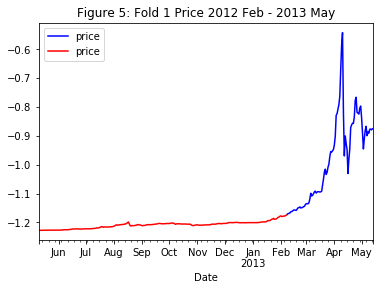

In [439]:
df['color'] = 'blue'
df.loc[:273,['color']] = 'red'
# df[0:370].plot(x='Date',y='price')
# df[0:273].plot(x='Date',y='price')
fig, ax = plt.subplots()
labels = []

for key, grp in df[:370].groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='price', c=key)
    labels.append(key)
    
plt.title("Figure 5: Fold 1 Price 2012 Feb - 2013 May")


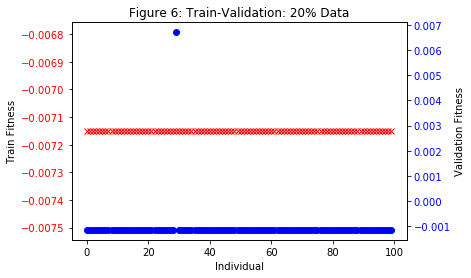

In [440]:
%matplotlib inline
def two_scales(ax1, n, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    
    ax1.plot(n, data1, 'rx', color = c1, )
    ax1.set_xlabel('Individual')
    ax1.set_ylabel('Train Fitness')
    
    ax2.plot(n, data2, 'bo', color = c2, )
    ax2.set_ylabel('Validation Fitness')
    return ax1, ax2

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

n = np.arange(100)

# 20
plt.figure()
fig_20, ax_20 = plt.subplots()
ax1, ax2 = two_scales(ax_20, n, 
                      np.asmatrix(RESULT[0][0])/73, 
                      np.asmatrix(RESULT[0][1])/73,
                      'r', 'b')
plt.title("Figure 6: Train-Validation: 20% Data")

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')

### (2) Observations on Fold2,3,4 Models:
Figure 7,8,9 also shows the performance of the fold2, fold3, fold4 models in terms of training fitness and validation fitness. First note that the validation scores are approximatey 10 folds smaller compared to the traning scores. This can be a sign of overfitting. I will explore more on this later with a learning curve. Secondly, as the amount of data increases, the population becomes more and more diverse. However, individuals in the 40-70 percentile hall of fame from the training sets sometimes do very well on the valdidation sets.

Fold:1: Fitness: -0.001 +/- 0.001
Fold:2: Fitness: 0.004 +/- 0.000
Fold:3: Fitness: 0.001 +/- 0.001
Fold:4: Fitness: 0.009 +/- 0.014
CV SCORE: 0.003 +/- 0.004


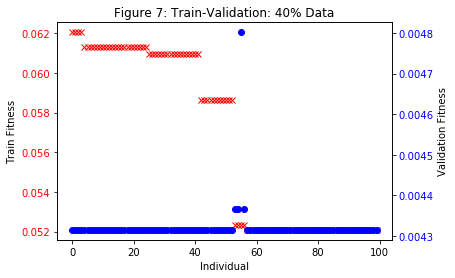

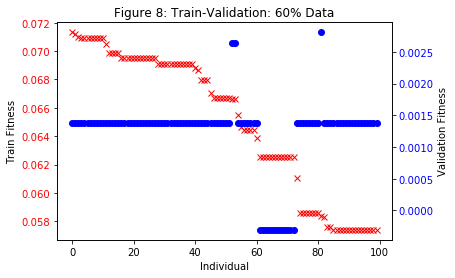

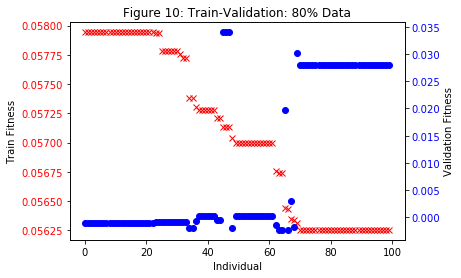

In [441]:
plt.figure()
fig_40, ax_40 = plt.subplots()
ax1, ax2 = two_scales(ax_40, n, 
                      np.asmatrix(RESULT[1][0])/146, 
                      np.asmatrix(RESULT[1][1])/146,
                      'r', 'b')
plt.title("Figure 7: Train-Validation: 40% Data")
color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')


# 
plt.figure()
fig_60, ax_60 = plt.subplots()
ax1, ax2 = two_scales(ax_60, n, 
                      np.asmatrix(RESULT[2][0])/219, 
                      np.asmatrix(RESULT[2][1])/219,
                      'r', 'b')
plt.title("Figure 8: Train-Validation: 60% Data")
color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')


# 80%
plt.figure()
fig_80, ax_80 = plt.subplots()
ax1, ax2 = two_scales(ax_80, n, 
                      np.asmatrix(RESULT[3][0])/292, 
                      np.asmatrix(RESULT[3][1])/292,
                      'r', 'b')
plt.title("Figure 10: Train-Validation: 80% Data")
color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')

MU = []
STD = []
for i in range(4):
    n, _ = cv_trainVal_sets[i][1].shape
    
    np.asmatrix(SCORE_VAL[0])    
    
    mu = np.mean(np.asmatrix(RESULT[i][1]))/n
    std = np.std(np.asmatrix(RESULT[i][1]))/n
    print('Fold:{}: Fitness: {:0.3f} +/- {:0.3f}'.format(
        i+1, 
        mu, std))
    
    MU.append(mu)
    STD.append(std)
    
print("CV SCORE: {:0.3f} +/- {:0.3f}".format(
    np.mean(MU),
    np.mean(STD)))

# PIK = "CV_result.dat"

# with open(PIK, "wb") as f:
#     pickle.dump(RESULT, f)
     
# with open(PIK, "rb") as f:
#     x =  pickle.load(f)

C2: Learning Curve
---
if a model is too complex for a given training dataset - there are too many degrees of freedom or parameters in this model - the model tends to overfit the training data and does not generalize well to unseen data. Often, it can help to collect more training samples to reduce the degree of overfitting. However, in practice, it can be very expensive or simply not feasible to collect more data. By plotting the model training and validation accuracies as functions of the training set size, we can easily detect whether the model suffers from high variance or high bias.

In this section, I subsampled the data for every 1,2,3,...,13 rows and trained the models. Since the computation is very expensive, I lowered the initial population to 100 and number of generations to stop to 5. It took approximately one hour to finish training 13 models. 

Figure 11 shows the result. It seems that the models do not do good with these parameters. But it does give a sense of how expensive it is to run a GP even on a small sample space

In [199]:
%%time
RESULT_LC = []
LOGS_LC = []

df_train_80 = df[:len(df)-len(df_test)]
df_test_20 = df_test

freqs = range(1,14,1)
subsampled_dfs = []
for f in freqs:
    subsampled_dfs.append(df_train_80.iloc[::f, :])
#     print(df_train_80.iloc[::f, :].shape)


for k in subsampled_dfs:
    df_train = k
    score_lc = []
    toolbox.register("evaluate", evalCoinInvestor, dataframe = df_train)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    pop_lc = toolbox.population(n=100)
    hof_lc = tools.HallOfFame(100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop_lc, logbook_lc = algorithms.eaSimple(pop, toolbox, 
                        0.5, # Mating Probablity
                        0.3,# Mutation Probablity
                        5, 
                        stats, halloffame=hof_lc)
    
    LOGS_LC.append(logbook_lc)
    
    for individual in hof_lc:
        score_lc.append(evalCoinInvestor(individual, df_train))

    RESULT_LC.append([score_lc, hof_lc])
    
# PIK = "LC_result.dat"
# with open(PIK, "wb") as f:
#     pickle.dump(RESULT_LC, f)

gen	nevals	avg    	std    	min    	max    
0  	0     	19.6588	12.2952	-5.3625	62.4793


C:\Users\Zhaokai\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


1  	344   	27.4732	16.5498	-4.68773	62.8391
2  	340   	36.3569	19.186 	-5.94711	62.8391
3  	334   	45.7471	17.9574	-4.40745	62.8391
4  	327   	48.9254	19.8824	-5.64266	62.8391
5  	346   	51.397 	19.9343	-4.40745	62.8391
gen	nevals	avg   	std    	min     	max    
0  	0     	51.397	19.9343	-4.40745	62.8391
1  	302   	38.176	21.1198	-2.58926	62.8391
2  	306   	36.4409	19.0629	-2.58926	62.8391
3  	337   	30.9919	18.347 	-2.58926	62.8391
4  	304   	30.3352	16.8418	-2.58926	62.8391
5  	322   	29.894 	16.5997	-2.58926	62.8391
gen	nevals	avg   	std    	min     	max    
0  	0     	29.894	16.5997	-2.58926	62.8391
1  	326   	24.0737	16.6194	-1.94764	62.8391
2  	324   	22.8273	17.1587	-1.94764	62.8391
3  	335   	21.6257	15.4397	-2.13203	62.8391
4  	303   	21.2155	15.102 	-1.94764	62.8391
5  	302   	22.3504	14.9804	-1.94764	62.8391
gen	nevals	avg    	std    	min     	max    
0  	0     	22.3504	14.9804	-1.94764	62.8391
1  	311   	19.1166	15.3636	-0.822993	62.8391
2  	309   	17.4721	14.5026	-0.822993

In [434]:
TEST_SCORES = []
TRAIN_SCORES = []

for i in range (0,13):
    x = [] #VAL SCPRES
    y = [] #TRAIN SCORES
    for j in range(0,100):
        x.append(evalCoinInvestor(RESULT_LC[i+1][1][j],df_test))
        y.append(evalCoinInvestor(RESULT_LC[i+1][0][j],df_test))
    TEST_SCORES.append(x)
    TRAIN_SCORES.append(y)

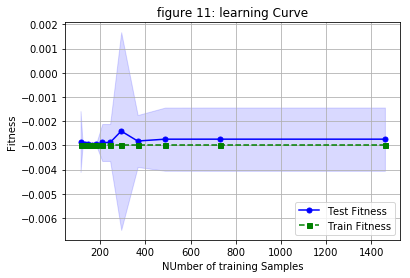

In [442]:
MU_test = []
STD_test = []
MU_train = []
STD_train = []

n_test = len(df_test)
for i in range(len(TEST_SCORES)):
    MU_test.append(np.mean(np.asmatrix(TEST_SCORES[i]))/n_test)
    STD_test.append(np.std(np.asmatrix(TEST_SCORES[i]))/n_test)
    
    MU_train.append(np.mean(np.asmatrix(TRAIN_SCORES[i]))/n_test)
    STD_train.append(np.std(np.asmatrix(TRAIN_SCORES[i]))/n_test)

sizes = []
for x in subsampled_dfs:
    sizes.append(len(x))

    
plt.plot(sizes, MU_test,
        color = 'blue', marker = 'o',
        markersize = 5,
        label = 'Test Fitness')

plt.fill_between(np.array(sizes), 
                 np.array(MU_test) + np.array(STD_test),
                 np.array(MU_test) - np.array(STD_test),
                alpha = 0.15, color = 'blue')

plt.plot(sizes, MU_train,
        color = 'green', 
        linestyle = '--',
        marker = 's',
        markersize = 5,
        label = 'Train Fitness')

plt.fill_between(np.array(sizes), 
                 np.array(MU_train) + np.array(STD_train),
                 np.array(MU_train) - np.array(STD_train),
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel("NUmber of training Samples")
plt.ylabel("Fitness")
plt.legend(loc = 'lower right')
plt.title("figure 11: learning Curve")

### C3: Hyperparameter Tunning

Normally it would be nice to tune a model through grid search by combinations of parameters. In GP, there are many options to tune with: mutation probablity, mating probablity, number of inital population, etc. Considering there exist various selections of mutation, crossover, selection methods and the expensive computation power. GP doesn't seem to be a good option for evloving a useful trading stratgy.

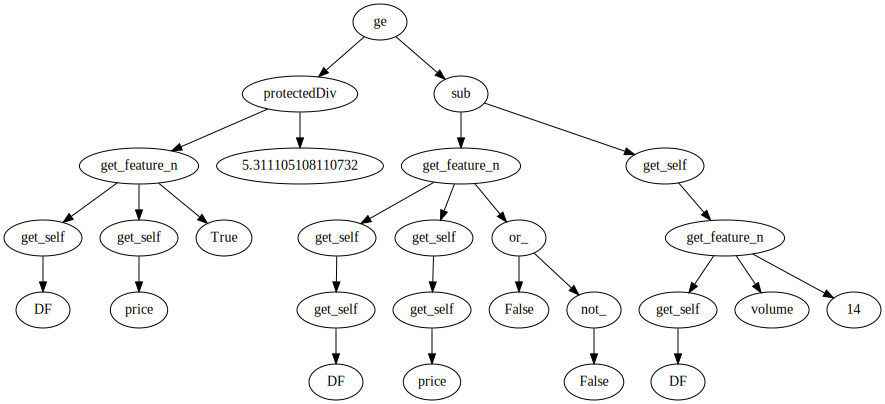

In [455]:
from deap import base, creator, gp
from graphviz import Digraph
from graphviz import Graph 


nodes, edges, labels = gp.graph(RESULT[1][2][10]) 


## Graphviz Plotting Session:
## GraphViz API: http://graphviz.readthedocs.io/en/stable/api.html?highlight=save

dot = Digraph()
dot.format = 'png'
# Add Nodes, Lables
for node,label in zip(nodes,labels):
    dot.node(str(node),str(labels[node]))

# Add Edges
for e in edges:
    dot.edge(str(e[0]), str(e[1]))


dot

D: Conclusion
===
In this project, I used [Distributed Evolutionary Algorithm in Python (DEAP)](http://deap.readthedocs.io/en/master/index.html) API to construct a GP architecture that aims to develop a profitable trading strategy for buying and selling bitcoin. I used excess return over buy-and-hold strategy as my fitness function. I performed cross-validation and learning curve plotting to understand the performance of my trading algorithm. Unfortunately, my models have very high variance and require a good amount of transactions and assets to be able to profit very slightly.

The advantage of GP is that it allows flexible interactions and constructions of functions using customized functions. A user needs not to tell a computer how to do but only what needs to be done. However, with many paraments to tune and crossover, mutation, selection method to choose from, GP seems to not to be a very useful tool for the current computers in terms of evloving a trading strategy. 

Defining functions that can operate on dataframe, such as calculate the derivate between two time points, might boost the performance of the models. But it also adds the risk of overfitting.

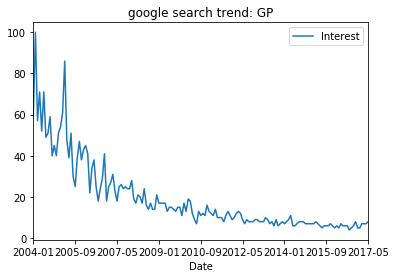

In [452]:
df_trend = pd.read_csv(input_dir + "\\multiTimeline.csv")
df_trend.plot(x="Date", y="Interest")
plt.title("google search trend: GP")